The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## step1: camera calibration

用到的opencv函数

1.得到灰度图

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

2.Finding chessboard corners (for an 8x6 board):

ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

3.Drawing detected corners on an image:

img = cv2.drawChessboardCorners(img, (8,6), corners, ret)

4.标定相机Camera calibration

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

objpoints:对象点坐标，3D points in real world space

imgpoints:图像点坐标，2D points in image plane

5.图像矫正：Undistorting a test image:

dst = cv2.undistort(img, mtx, dist, None, mtx)

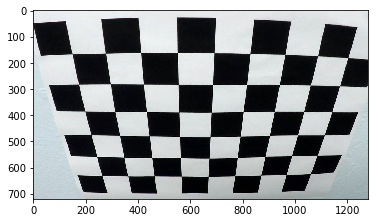

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

fname = './camera_cal/calibration2.jpg'
img = cv2.imread(fname)

plt.imshow(img)

corners find

### 求得角点

In [14]:
import glob
# Read in and make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')


# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y


#Arrays to store object points and image points from all the images
objpoints = []  #3D points in real world space
imgpoints= []   #2D points in image plane
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


for fname in images:
    #read in each image
    img = cv2.imread(fname)
     
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)
        #plt.show()
        


In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

## step2: 畸变矫正

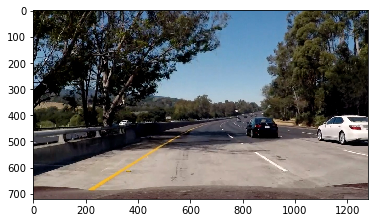

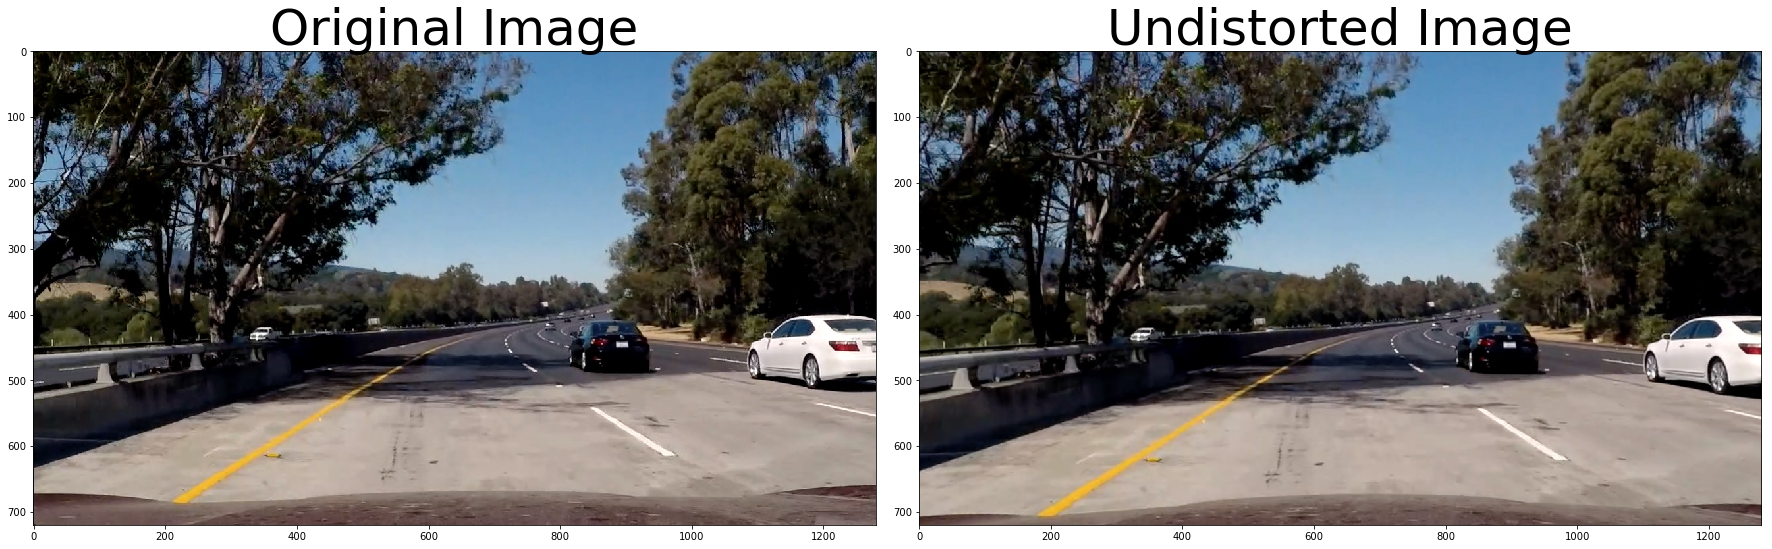

In [21]:
# Read in an image
img = cv2.imread('./test_images/test5.jpg')
plt.imshow(img[:,:,::-1])
plt.show()
# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1],img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    #undist = np.copy(img)  # Delete this line
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img[:,:,::-1])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted[:,:,::-1])
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## step3: 得到车道线阈值图

## step4: 视角透视转换，得到bird eye view

## step5: 拟合车道线曲线

## step6: 画出车道线，转换回原图

## step7: 测试视频
